In [1]:
import os
import json
import math
import numpy as np 
import time

import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
from matplotlib.colors import to_rgb
import matplotlib
import seaborn as sns
import networkx as nx

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms

import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

from tqdm.notebook import tqdm

import urllib.request
from urllib.error import HTTPError


# Init and Downloading

In [10]:
%matplotlib inline 
matplotlib.rcParams['lines.linewidth'] = 2.0
sns.reset_orig()
sns.set()

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "./tmp_dataset"
os.makedirs(DATASET_PATH, exist_ok=True)
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "./tmp_saved_models/"
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# mps is for apple macbooks
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
# this sets the default device for all torch operations, to avoid unexpected conflicts
torch.set_default_device(device)
print(device)

Seed set to 42


mps


In [3]:
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial7/"
# Files to download
pretrained_files = ["NodeLevelMLP.ckpt", "NodeLevelGNN.ckpt", "GraphLevelGraphConv.ckpt"]

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if "/" in file_name:
        os.makedirs(file_path.rsplit("/",1)[0], exist_ok=True)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)

## Graph representation

Mathematically, a graph ($\mathcal{G}$) is defined as a tuple of a set of nodes/vertices ($V$), and a set of edges/links ( $E$: $\mathcal{G}=(V,E)$ ). For instance:

<center width="100%" style="padding:10px"><img src="example_graph.svg" width="250px"></center>

- Vertices $V=\{1,2,3,4\}$
- Edges $E=\{(1,2), (2,3), (2,4), (3,4)\}$
- We assume the graph to be undirected and hence don't add mirrored pairs like $(2,1)$

For an undirected graph, $A$ is a symmetric matrix ($A_{ij}=A_{ji}$). We have the following adjacency matrix:

$$
A = \begin{bmatrix}
    0 & 1 & 0 & 0\\
    1 & 0 & 1 & 1\\
    0 & 1 & 0 & 1\\
    0 & 1 & 1 & 0
\end{bmatrix}
$$

- Expressing a graph as a **list of edges** is **more efficient** in terms of memory and (possibly) computation, but using an adjacency matrix simpler to implement.
- _We will implement the adjacency matrix_ to keep the code simple.
- Alternatively, we could also use the list of edges to _define a sparse adjacency matrix_ with which we can work as if it was a dense matrix, but allows more memory-efficient operations.


## Graph Convolutions

- GCNs are similar to convolutions in images in the sense that the “filter” parameters are typically shared over all locations in the graph.
- At the same time, GCNs rely on message passing methods, which means that vertices exchange information with the neighbors, and send “messages” to each other.

1. The first step is that each node creates a feature vector that represents the message it wants to send to all its neighbors.
2. In the second step, the messages are sent to the neighbors, so that a node receives one message per adjacent node. 

Below we have visualized the two steps for our example graph. 

<center width="100%" style="padding:10px"><img src="graph_message_passing.svg" width="700px"></center>

**How to combine all the messages a node receives?**<br>
As the number of messages vary across nodes, we need an operation that works for any number. Hence, **sum** or **take the mean.**.
The GCN layer is defined as follows:

$$H^{(l+1)} = \sigma\left(\hat{D}^{-1/2}\hat{A}\hat{D}^{-1/2}H^{(l)}W^{(l)}\right)$$

Looking at the equation from **right to left:**

$H^{(l)}$ : the previous features of **all** nodes. Each row represents the feature vector of a node.

$W^{(l)}$ :  the weight matrix of learnable parameters at layer $l$.

$H^{(l)}W^{(l)}$ : the weighted average of the previous features (new messages)

$A$ : the adjacency matrix

$\hat{A}=A+I$ : we add the identity matrix to the adjacency matrix so that each node sends its own message to itself too

$\hat{D}$ : the diagonal degree matrix corresponding to $\hat{A}$, where each diagonal entry $D_{ii}$ represents the number of neighbors (including itself, due to $I$) of node $i$. This matrix is used for normalization purposes.

$\hat{D}^{-1/2}$ : is the inverse square root of the degree matrix. For a diagonal matrix, this operation is performed element-wise on the diagonal.

$\hat{D}^{-1/2}\hat{A}\hat{D}^{-1/2}$ : this term serves as a normalization technique for the adjacency matrix, preventing the scale of node features from growing or shrinking drastically as they propagate through the network layers. In other words, this normalization ensures that nodes with many connections don't overwhelm the computation, and nodes with fewer connections aren't overlooked.

$\sigma$ : represents an arbitrary activation function, and not necessarily the sigmoid (usually a ReLU-based activation function is used in GNNs).

$H^{(l+1)}$ : the new (current) features of **all** nodes

> Note: the standard matrix multiplication is the dot product, for example in $H^{(l)}W^{(l)}$.

In [4]:
class GCNLayer(nn.Module):
    def __init__(self, c_in, c_out):
        """
        Args:
            c_in (int): Number of input features per node.
            c_out (int): Number of output features per node.
        """
        super().__init__()

        # the weight matrix W in the GCN equation
        # a linear transformation layer to project input features to output features
        self.projection = nn.Linear(c_in, c_out)

    def forward(self, node_feats, adj_matrix):
        """
        The forward pass.
        Assumes identity connections (i.e., self-connections) are already added to the adjacency matrix.

        Args:
            node_feats: Node feature tensor of shape [batch_size, num_nodes, c_in]
            adj_matrix: Adjacency matrix tensor of shape [batch_size, num_nodes, num_nodes]
        Returns:
            Updated node features of shape [batch_size, num_nodes, c_out]
        """
        # Calculate the number of neighbors (incoming edges) for each node by summing over the last dimension of the adjacency matrix. The resulting tensor has shape [batch_size, num_nodes, 1], where each value represents the number of neighbors
        num_neighbours = adj_matrix.sum(dim=-1, keepdims=True)

        # Project node features using the weight matrix W
        new_node_feats = self.projection(node_feats)

        # matrix multiplication of adjacency matrix and each node features
        # aggregating features from neighboring nodes for each node
        # from: https://pytorch.org/docs/stable/generated/torch.bmm.html
        # if mat1 is (b×n×m) and mat2 is (b×m×p), the result will be a (b×n×p) tensor
        av_node_feats = torch.bmm(adj_matrix, new_node_feats)

        # Normalize the aggregated features by dividing by the number of neighbors.
        # This takes the mean of the neighbors' features instead of summing.
        # Shape remains [batch_size, num_nodes, c_out]
        norm_node_feats = av_node_feats / num_neighbours

        return norm_node_feats


In [18]:
# helper function to draw the graph from the adjacency matrix
def plot_graph(adj_matrix, remove_self_loops=True, device="cpu"):
    """
    Visualize a graph from an adjacency matrix.
    
    Parameters:
    adj_matrix (torch.Tensor): Adjacency matrix of shape [batch_size, num_nodes, num_nodes]
    remove_self_loops (bool): If True, removes the identity matrix from adj_matrix
    
    Returns:
    matplotlib.figure.Figure: The figure containing the graph visualization
    matplotlib.axes._subplots.AxesSubplot: The axes containing the graph visualization
    """
    # Ensure the input is a 3D tensor
    if adj_matrix.dim() == 2:
        adj_matrix = adj_matrix.unsqueeze(0).to(device)
    
    # Remove self-loops if specified
    if remove_self_loops:
        identity = torch.eye(adj_matrix.size(1)).unsqueeze(0).to(device)
        adj_matrix = adj_matrix - identity
    
    # Convert to numpy for NetworkX
    adj_np = adj_matrix.squeeze().to(device).numpy()

    # Create a graph
    G = nx.Graph(adj_np)

    # Set up the plot
    fig, ax = plt.subplots()

    # Draw the graph
    pos = nx.spring_layout(G)
    nx.draw(G, pos, ax=ax, with_labels=True, node_color='lightblue', 
            node_size=500, font_size=16, font_weight='bold')

    # Add edge labels
    edge_labels = {(u, v): '' for u, v in G.edges()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, ax=ax)

    # Remove axis
    ax.axis('off')
    
    # Adjust layout
    plt.tight_layout()
    
    return fig, ax


Node features:
 tensor([[[0., 1.],
         [2., 3.],
         [4., 5.],
         [6., 7.]]], device='mps:0')

Adjacency matrix:
 tensor([[[1., 1., 0., 0.],
         [1., 1., 1., 1.],
         [0., 1., 1., 1.],
         [0., 1., 1., 1.]]])


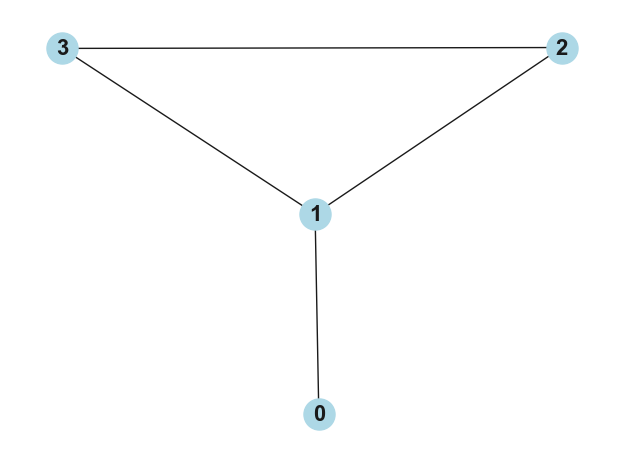

In [23]:
# 1 batch, 4 nodes per batch, 2 features per node
node_feats = torch.arange(8, dtype=torch.float32).view(1, 4, 2)

# note that the identity connections are already included in the adjacency matrix
adj_matrix = torch.Tensor([[[1, 1, 0, 0],
                            [1, 1, 1, 1],
                            [0, 1, 1, 1],
                            [0, 1, 1, 1]]])

print("Node features:\n", node_feats)
print("\nAdjacency matrix:\n", adj_matrix)
fig, ax = plot_graph(adj_matrix)
plt.show()